In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# 模型
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [3]:
#加载数据
data_train = pd.read_csv('./data/zhengqi_train.txt',sep = '\t')
data_test = pd.read_csv('./data/zhengqi_test.txt',sep = '\t')

In [4]:
#合并训练数据和测试数据
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)
#显示前5条数据
data_all.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V30,V31,V32,V33,V34,V35,V36,V37,target,oringin
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175,train
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676,train
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633,train
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206,train
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384,train


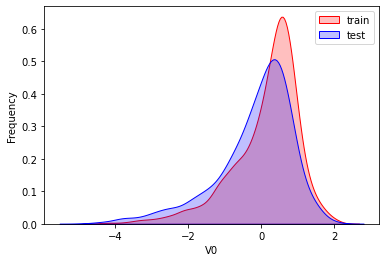

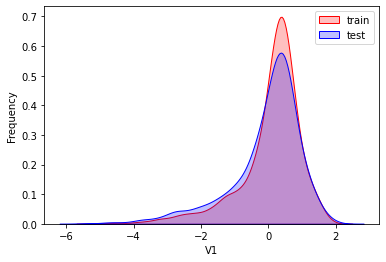

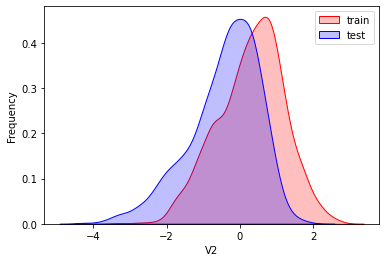

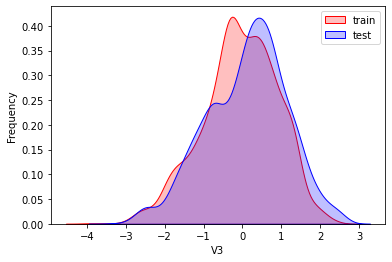

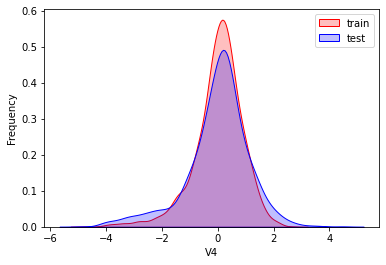

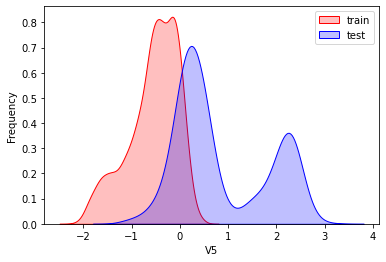

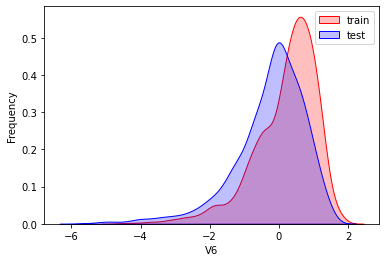

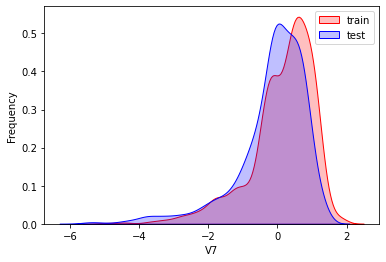

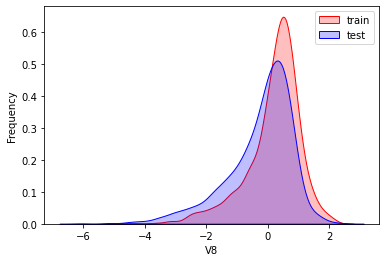

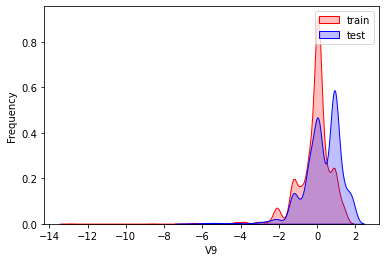

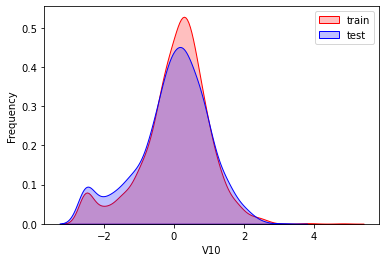

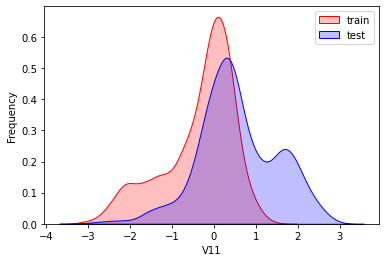

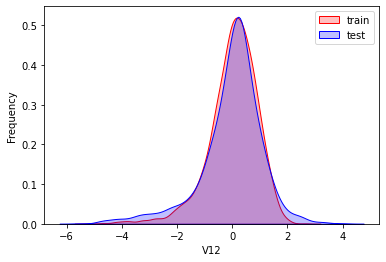

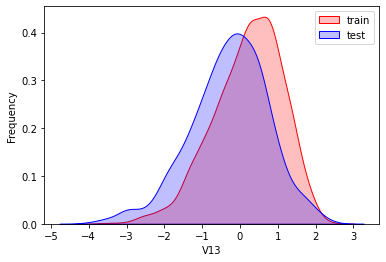

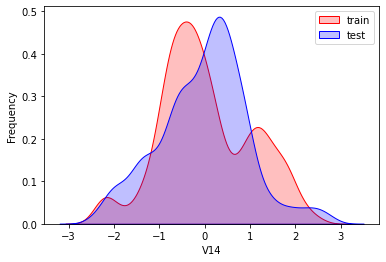

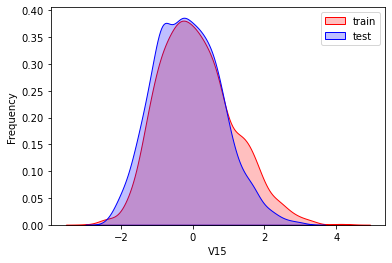

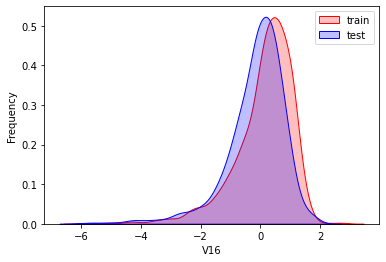

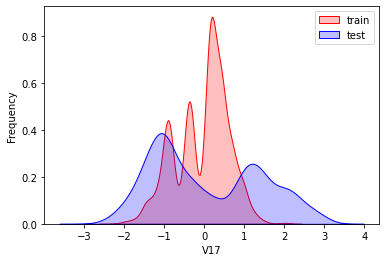

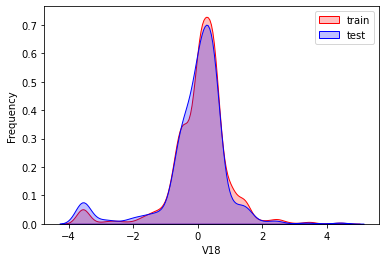

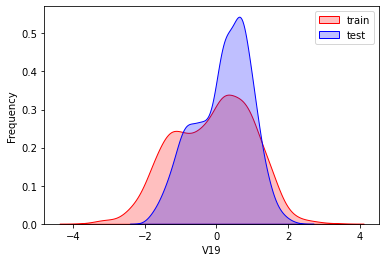

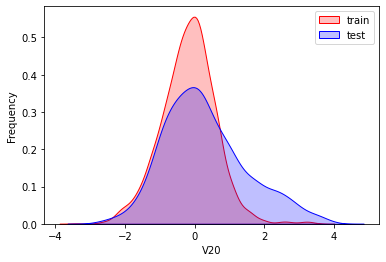

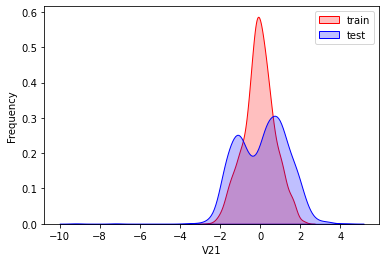

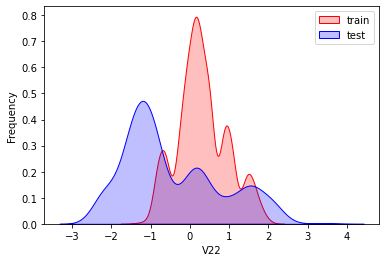

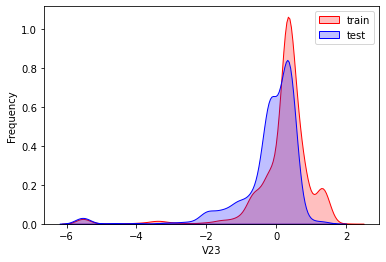

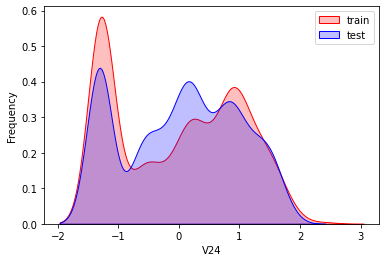

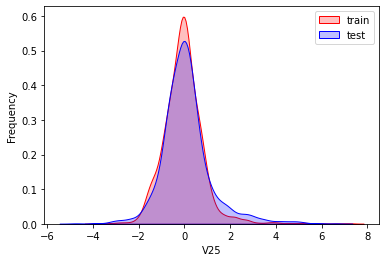

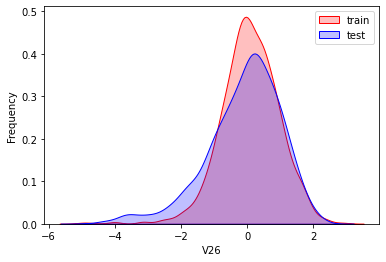

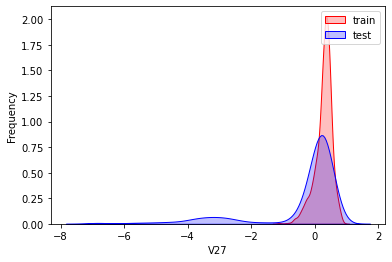

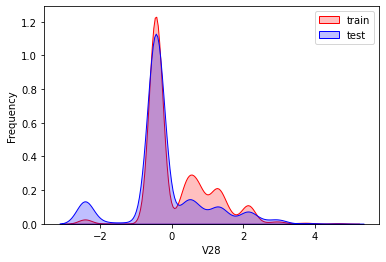

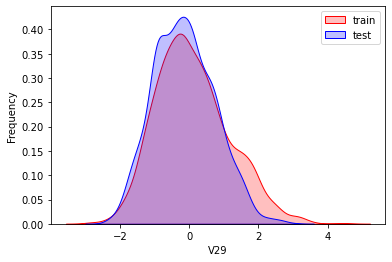

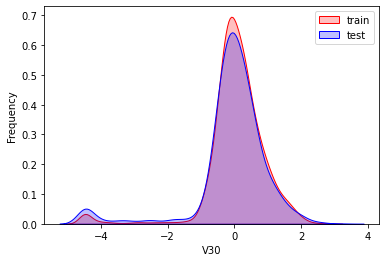

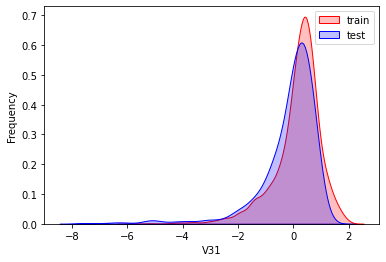

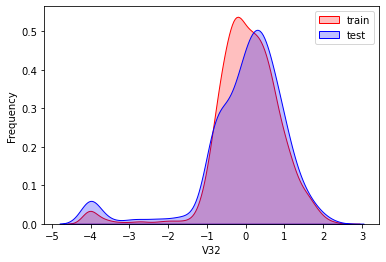

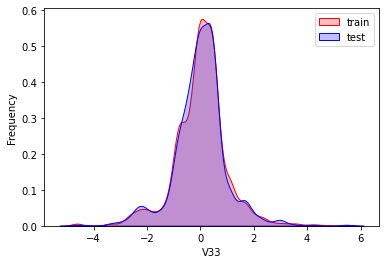

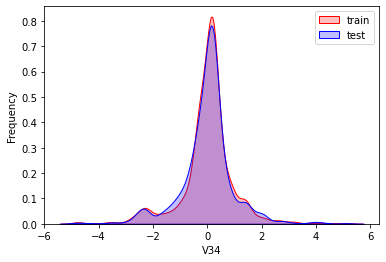

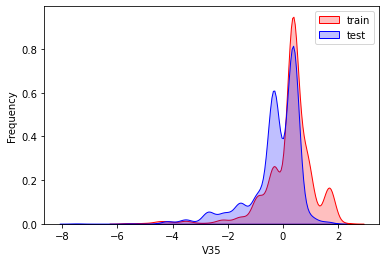

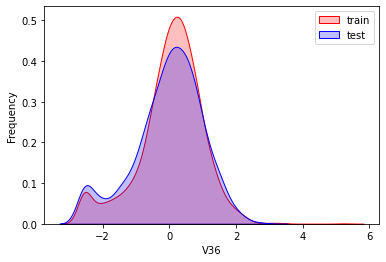

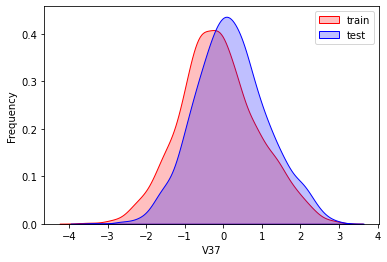

In [5]:
# 探索数据分布
#fig = plt.figure(figsize=(6, 6))
for column in data_all.columns[0:-2]:
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

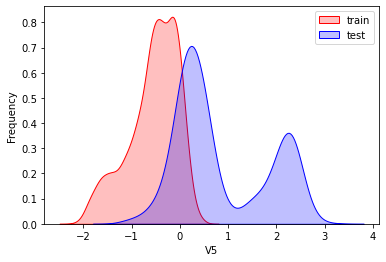

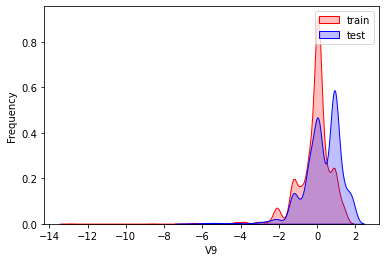

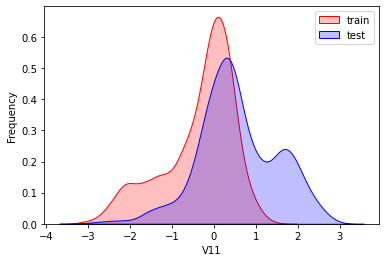

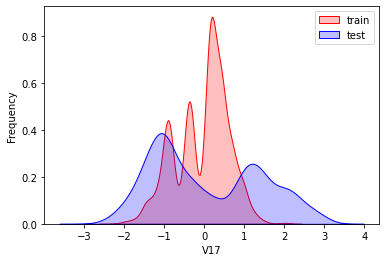

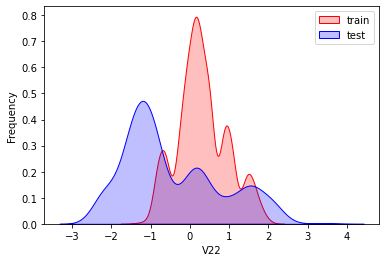

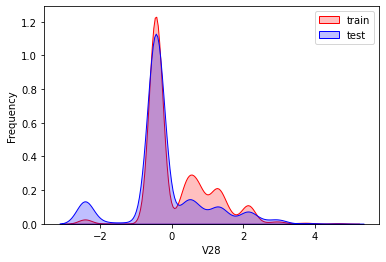

In [6]:
#删除特征"V5","V9","V11","V17","V22","V28"，训练集和测试集分布不均
for column in ["V5","V9","V11","V17","V22","V28"]:
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

# 删除分布不均的特征后，建立模型看看效果

In [7]:
data_all.head()

,V0,V1,V2,V3,V4,V6,V7,V8,V10,V12,...,V30,V31,V32,V33,V34,V35,V36,V37,target,oringin
0,0.566,0.016,-0.143,0.407,0.452,-1.812,-2.360,-0.436,-0.940,-0.073,...,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175,train
1,0.968,0.437,0.066,0.566,0.194,-1.566,-2.360,0.332,0.188,-0.134,...,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676,train
2,1.013,0.568,0.235,0.370,0.112,-1.367,-2.360,0.396,0.874,-0.072,...,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633,train
3,0.733,0.368,0.283,0.165,0.599,-1.200,-2.086,0.403,0.011,-0.014,...,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206,train
4,0.684,0.638,0.260,0.209,0.337,-1.073,-2.086,0.314,-0.251,0.199,...,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384,train


In [20]:
X=np.array(data_all[(data_all['oringin']=='train')].drop(['target','oringin'], axis = 1))# 语法：先筛再选
y=np.array(data_all[(data_all['oringin']=='train')]['target'])
zhengqi_test=np.array(data_all[(data_all['oringin']=='test')].drop(['target','oringin'], axis = 1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,y_train)
y_train_pred_lr=LR.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_train_pred_lr))
y_test_pred_lr=LR.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_lr))

训练集误差： 0.11181915638852426
验证集误差： 0.1109937961095697


In [23]:
from sklearn.svm import LinearSVR
LSVR=LinearSVR()
LSVR.fit(X_train,y_train)
y_train_pred_LSVR=LSVR.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_train_pred_LSVR))
y_test_pred_LSVR=LSVR.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_LSVR))

训练集误差： 0.11377630316900923
验证集误差： 0.11371647467531795


In [24]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
y_train_pred_rf=rf.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_train_pred_rf))
y_test_pred_rf=rf.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_rf))

训练集误差： 0.017363318607521022
验证集误差： 0.12541264175686276


In [25]:
from xgboost import XGBRegressor
xgbr=XGBRegressor()
xgbr.fit(X_train,y_train)
y_train_pred_xgbr=xgbr.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_train_pred_xgbr))
y_test_pred_xgbr=xgbr.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_xgbr))

训练集误差： 0.0004093691495493975
验证集误差： 0.13810983593922202


In [26]:
from lightgbm import LGBMRegressor 
lgbmr=LGBMRegressor()
lgbmr.fit(X_train,y_train)
y_train_pred_lgbmr=lgbmr.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_train_pred_lgbmr))
y_test_pred_lgbmr=lgbmr.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_lgbmr))

训练集误差： 0.013450203368885172
验证集误差： 0.11716523977671471


In [27]:
from catboost import CatBoostRegressor
catbr=CatBoostRegressor()
catbr.fit(X_train,y_train)
y_pred_catbr=catbr.predict(X_train)
print('训练集误差：',mean_squared_error(y_train,y_pred_catbr))
y_test_pred_catbr=lgbmr.predict(X_test)
print('验证集误差：',mean_squared_error(y_test,y_test_pred_catbr))

Learning rate set to 0.045757
0:	learn: 0.9447809	total: 173ms	remaining: 2m 52s
1:	learn: 0.9144457	total: 175ms	remaining: 1m 27s
2:	learn: 0.8866653	total: 178ms	remaining: 59.1s
3:	learn: 0.8628972	total: 180ms	remaining: 44.8s
4:	learn: 0.8363483	total: 182ms	remaining: 36.2s
5:	learn: 0.8106686	total: 184ms	remaining: 30.4s
6:	learn: 0.7888698	total: 185ms	remaining: 26.3s
7:	learn: 0.7671650	total: 187ms	remaining: 23.2s
8:	learn: 0.7468998	total: 189ms	remaining: 20.8s
9:	learn: 0.7271197	total: 190ms	remaining: 18.8s
10:	learn: 0.7093854	total: 192ms	remaining: 17.3s
11:	learn: 0.6914733	total: 194ms	remaining: 16s
12:	learn: 0.6734822	total: 196ms	remaining: 14.9s
13:	learn: 0.6574845	total: 197ms	remaining: 13.9s
14:	learn: 0.6418522	total: 199ms	remaining: 13.1s
15:	learn: 0.6264672	total: 200ms	remaining: 12.3s
16:	learn: 0.6112539	total: 202ms	remaining: 11.7s
17:	learn: 0.5976666	total: 204ms	remaining: 11.1s
18:	learn: 0.5842877	total: 205ms	remaining: 10.6s
19:	learn: 

217:	learn: 0.2648337	total: 531ms	remaining: 1.91s
218:	learn: 0.2644450	total: 533ms	remaining: 1.9s
219:	learn: 0.2641091	total: 535ms	remaining: 1.9s
220:	learn: 0.2636811	total: 537ms	remaining: 1.89s
221:	learn: 0.2634278	total: 539ms	remaining: 1.89s
222:	learn: 0.2631932	total: 541ms	remaining: 1.88s
223:	learn: 0.2629021	total: 542ms	remaining: 1.88s
224:	learn: 0.2624886	total: 544ms	remaining: 1.87s
225:	learn: 0.2621104	total: 546ms	remaining: 1.87s
226:	learn: 0.2617919	total: 547ms	remaining: 1.86s
227:	learn: 0.2613618	total: 549ms	remaining: 1.86s
228:	learn: 0.2610071	total: 551ms	remaining: 1.85s
229:	learn: 0.2607856	total: 552ms	remaining: 1.85s
230:	learn: 0.2602550	total: 554ms	remaining: 1.84s
231:	learn: 0.2598813	total: 556ms	remaining: 1.84s
232:	learn: 0.2593332	total: 557ms	remaining: 1.83s
233:	learn: 0.2589440	total: 559ms	remaining: 1.83s
234:	learn: 0.2586769	total: 561ms	remaining: 1.82s
235:	learn: 0.2582025	total: 562ms	remaining: 1.82s
236:	learn: 0.

434:	learn: 0.1995042	total: 891ms	remaining: 1.16s
435:	learn: 0.1991091	total: 893ms	remaining: 1.15s
436:	learn: 0.1988905	total: 895ms	remaining: 1.15s
437:	learn: 0.1986692	total: 897ms	remaining: 1.15s
438:	learn: 0.1983748	total: 899ms	remaining: 1.15s
439:	learn: 0.1982283	total: 900ms	remaining: 1.15s
440:	learn: 0.1979340	total: 902ms	remaining: 1.14s
441:	learn: 0.1976172	total: 904ms	remaining: 1.14s
442:	learn: 0.1973772	total: 905ms	remaining: 1.14s
443:	learn: 0.1972335	total: 907ms	remaining: 1.14s
444:	learn: 0.1970287	total: 908ms	remaining: 1.13s
445:	learn: 0.1968754	total: 910ms	remaining: 1.13s
446:	learn: 0.1966393	total: 912ms	remaining: 1.13s
447:	learn: 0.1964218	total: 913ms	remaining: 1.13s
448:	learn: 0.1962131	total: 915ms	remaining: 1.12s
449:	learn: 0.1960041	total: 917ms	remaining: 1.12s
450:	learn: 0.1957978	total: 919ms	remaining: 1.12s
451:	learn: 0.1953915	total: 920ms	remaining: 1.11s
452:	learn: 0.1952076	total: 922ms	remaining: 1.11s
453:	learn: 

650:	learn: 0.1566444	total: 1.25s	remaining: 671ms
651:	learn: 0.1565081	total: 1.25s	remaining: 669ms
652:	learn: 0.1564527	total: 1.25s	remaining: 667ms
653:	learn: 0.1562463	total: 1.26s	remaining: 665ms
654:	learn: 0.1560642	total: 1.26s	remaining: 662ms
655:	learn: 0.1559607	total: 1.26s	remaining: 660ms
656:	learn: 0.1559037	total: 1.26s	remaining: 658ms
657:	learn: 0.1557152	total: 1.26s	remaining: 656ms
658:	learn: 0.1555576	total: 1.26s	remaining: 655ms
659:	learn: 0.1555173	total: 1.27s	remaining: 653ms
660:	learn: 0.1553508	total: 1.27s	remaining: 651ms
661:	learn: 0.1553007	total: 1.27s	remaining: 649ms
662:	learn: 0.1551286	total: 1.27s	remaining: 647ms
663:	learn: 0.1548619	total: 1.27s	remaining: 645ms
664:	learn: 0.1545612	total: 1.27s	remaining: 642ms
665:	learn: 0.1542218	total: 1.28s	remaining: 641ms
666:	learn: 0.1541593	total: 1.28s	remaining: 639ms
667:	learn: 0.1540236	total: 1.28s	remaining: 636ms
668:	learn: 0.1539832	total: 1.28s	remaining: 634ms
669:	learn: 

864:	learn: 0.1228090	total: 1.61s	remaining: 251ms
865:	learn: 0.1226251	total: 1.61s	remaining: 249ms
866:	learn: 0.1224519	total: 1.61s	remaining: 248ms
867:	learn: 0.1223137	total: 1.61s	remaining: 246ms
868:	learn: 0.1221596	total: 1.62s	remaining: 244ms
869:	learn: 0.1220782	total: 1.62s	remaining: 242ms
870:	learn: 0.1218920	total: 1.62s	remaining: 240ms
871:	learn: 0.1217136	total: 1.62s	remaining: 238ms
872:	learn: 0.1216808	total: 1.62s	remaining: 236ms
873:	learn: 0.1215423	total: 1.63s	remaining: 234ms
874:	learn: 0.1215261	total: 1.63s	remaining: 233ms
875:	learn: 0.1214050	total: 1.63s	remaining: 231ms
876:	learn: 0.1212561	total: 1.63s	remaining: 229ms
877:	learn: 0.1211462	total: 1.63s	remaining: 227ms
878:	learn: 0.1209824	total: 1.64s	remaining: 225ms
879:	learn: 0.1208654	total: 1.64s	remaining: 223ms
880:	learn: 0.1206847	total: 1.64s	remaining: 221ms
881:	learn: 0.1205220	total: 1.64s	remaining: 220ms
882:	learn: 0.1203815	total: 1.64s	remaining: 218ms
883:	learn: 

# 选择测试集最好的结果

In [30]:
result=LR.predict(np.array(zhengqi_test))
pd.DataFrame(result).to_csv('result_20220421_LR.txt',index=False,header=False)# 2.2922 
# 好奇葩的现象，为什么LR在训练集和测试集的结果都最好，一上线就是最烂的

In [31]:
result=LSVR.predict(np.array(zhengqi_test))
pd.DataFrame(result).to_csv('result_20220421_LSVR.txt',index=False,header=False)# 2.2922

In [32]:
result=rf.predict(np.array(zhengqi_test))
pd.DataFrame(result).to_csv('result_20220421_rf.txt',index=False,header=False)# 0.1424

In [33]:
result=catbr.predict(np.array(zhengqi_test))
pd.DataFrame(result).to_csv('result_20220421_catbr.txt',index=False,header=False)# 0.1403 还不如第一次暴力法的好